# Setup

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ssm import *
#from ssm.ssm.files.util import find_permutation
import pandas as pd
import os
npr.seed(0)

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = '/Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/MA2/projet_sem/visual-perception'
root_dir = os.getcwd()

### what to do
save_data = True

## Initialize GLM-HMM

## Load and prepare inputs

In [9]:
### read and data 
dfs = []
columns_to_keep = ['theta', 'resp', 'block']

for i in range (5):
    df = {}
    df[i+1] = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
    df[i+1]['ID'] = i+1  
    df[i+1]['prev_resp'] = df[i+1].groupby('block')['resp'].shift(1, fill_value=0)
    dfs.append(df[i+1])

final_df = pd.concat(dfs, ignore_index=True)
final_df = final_df[['ID', 'block', 'theta', 'prev_resp', 'resp']]
final_df['resp'] = final_df['resp'].replace(-1, 0)
final_df.to_csv(root_dir + '/Full_Data.csv', index=False)

In [ ]:
isi,block,trial,isi_ms,isi_frames,theta,log_cnt,resp,rt,stim_duration,blank_duration,cnt,correct
33,1,1,640,64,-45,-1.8546873026985,-1,0.546695,0.0482276000002457,0.645238199999767,0.0139737412527265,1

In [12]:
summary = {}
for col in final_df.columns:
    unique_values = final_df[col].unique()
    summary[col] = unique_values.tolist()
for col, types in summary.items():
    print(f"{col}: {types}")

ID: [1, 2, 3, 4, 5]
block: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
theta: [-45, 45]
prev_resp: [0, -1, 1]
resp: [0, 1]


In [13]:
### Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2        # input dimensions
N_iters = 500

In [15]:
inpts = []
choices = []
participants = final_df["ID"].unique()

for load_idx in participants:
    this_data = final_df.loc[final_df['ID'] == load_idx].copy()
        ## start with estimating the experiment as a whole
    num_sess = 1
    num_trials_per_sess = len(this_data)

    new_inpts = []
    new_choices = []

    new_inpts = np.ones((num_trials_per_sess, input_dim))

    ## get input format
    new_inpts[:, 0] = this_data['theta'].copy()
    new_inpts[:, 1] = this_data['prev_resp'].copy()
    #new_inpts[:, 2] = this_data['previous_contrast'].copy()
    #new_inpts[:, 2] = np.ones(this_data.shape[0])
    inpts.append(new_inpts)

    new_choices = this_data['resp'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices) 

## Fit at group-level in one-state GLM-HMM

In [16]:
### fit one state GLM-HMM at group level

num_states = 1
n_iter = 100

transition_alpha = 1
prior_sigma = 10

iter_array = np.full([n_iter, 2], np.nan)
for idx in range(n_iter):
    
    one_state_glmhmm = HMM(num_states, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    print(one_state_glmhmm.params)
    one_state_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,2))


((array([-0.]),), (array([[0.]]),), array([[[0.74159174, 1.55291372]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.86755799, -0.97727788]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.26611853, -0.50587654]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.76103773, 0.12167502]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.48431215, 0.57914048]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.49407907, -0.20515826]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.96075461,  0.37692697]]]))
((array([-0.]),), (array([[0.]]),), array([[[-2.55298982,  0.6536186 ]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.24214951,  1.51439128]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.04575852, -0.18718385]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.56644004, 0.14926509]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.88778575, -1.98079647]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.17538653, -0.46250554]]]))
((array([-0.]),), (array([[0.]]),

In [18]:
df_iter_array = pd.DataFrame(iter_array, columns = ['theta', 'prev_resp'])
if save_data:
    df_iter_array.to_csv(root_dir + '/HMM/one_level_HMM_params.csv', index = False) 

In [19]:
df_iter_array = pd.read_csv(root_dir + '/HMM/one_level_HMM_params.csv')
params_for_initalization = df_iter_array.mean().values
print(params_for_initalization)

[-0.02170771 -0.23100328]


# Fit multi-state GLM-HMMs at group-level and compare BIC

In [30]:
## compare models based on BIC
max_num_states =  2    # number of discrete states

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM
prior_sigma = 10
transition_alpha = 1

BIC = []
for state_idx in range(max_num_states): 
    print(state_idx)
    compare_glmhmm = ssm.HMM(state_idx+1, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

    
    _ = compare_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    n_total_params = np.concatenate(compare_glmhmm.observations.params).size + np.concatenate(compare_glmhmm.transitions.params).size
    
    # Flatten choices and inpts to calculate log likelihood correctly
    flattened_choices = np.concatenate(choices)
    flattened_inpts = np.concatenate(inpts)

    new_BIC = np.log(np.size(flattened_choices))*n_total_params - 2*compare_glmhmm.log_likelihood(choices, inputs=inpts)
    
    if save_data:
        pd.DataFrame(np.append(new_BIC, np.concatenate(compare_glmhmm.observations.params))).to_csv(root_dir + '/HMM/Full_model_outcome_states_' + str(state_idx + 1) + '.csv', index = False)

    BIC = np.append(BIC, new_BIC) 
    print(compare_glmhmm.observations.params)

df_BIC = pd.DataFrame({'BIC': BIC, 'num_states': np.arange(max_num_states) + 1})


if save_data:
    df_BIC.to_csv(root_dir + '/HMM/BIC_across_models.csv', index = False)


0
[[[-1.04758148 -0.47691989]]]
1
[[[-0.99910348 -1.41106381]]

 [[-1.19839237 -0.04329078]]]


array([-1117.0134779])

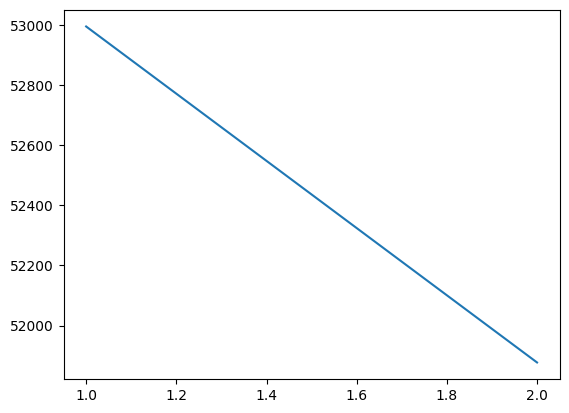

In [31]:
df_BIC = pd.read_csv(root_dir + '/HMM/BIC_across_models.csv')
plt.plot(df_BIC['num_states'], df_BIC['BIC'])
np.diff(df_BIC.BIC)

# Fit permuted multi-state GLM-HMMs at group-level and compare BIC

In [32]:
# Permutation analysis
n_perm = 100
BIC_permuted = []

for perm_idx in range(n_perm):
    permuted_choices = []
    permuted_inpts = []
    
    for i in range(len(choices)):
        perm_indices = np.random.permutation(choices[i].shape[0])
        permuted_choices.append(choices[i][perm_indices])
        permuted_inpts.append(inpts[i][perm_indices])
    
    for state_idx in range(max_num_states):
        print(f"Permutation {perm_idx}, State {state_idx}")
        permuted_glmhmm = ssm.HMM(state_idx + 1, obs_dim, input_dim, 
                                  observations="input_driven_obs", 
                                  observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                                  transitions="sticky", 
                                  transition_kwargs=dict(alpha=transition_alpha, kappa=0))

        _ = permuted_glmhmm.fit(permuted_choices, inputs=permuted_inpts, method="em", num_iters=N_iters, initialize=True, tolerance=10**-4, verbose=False)

        n_total_params = np.concatenate(permuted_glmhmm.observations.params).size + np.concatenate(permuted_glmhmm.transitions.params).size

        # Compute log likelihood
        log_likelihood = permuted_glmhmm.log_likelihood(permuted_choices, inputs=permuted_inpts)

        # Compute BIC
        new_BIC = np.log(len(flattened_choices)) * n_total_params - 2 * log_likelihood
        BIC_permuted.append({'perm_idx': perm_idx, 'state_idx': state_idx + 1, 'BIC': new_BIC})

df_BIC_permuted = pd.DataFrame(BIC_permuted)
if save_data:
    df_BIC_permuted.to_csv(root_dir + '/HMM/BIC_permuted_across_models.csv', index=False)

Permutation 0, State 0
Permutation 0, State 1
Permutation 1, State 0
Permutation 1, State 1
Permutation 2, State 0
Permutation 2, State 1
Permutation 3, State 0
Permutation 3, State 1
Permutation 4, State 0
Permutation 4, State 1
Permutation 5, State 0
Permutation 5, State 1
Permutation 6, State 0
Permutation 6, State 1
Permutation 7, State 0
Permutation 7, State 1
Permutation 8, State 0
Permutation 8, State 1
Permutation 9, State 0
Permutation 9, State 1
Permutation 10, State 0
Permutation 10, State 1
Permutation 11, State 0
Permutation 11, State 1
Permutation 12, State 0
Permutation 12, State 1
Permutation 13, State 0
Permutation 13, State 1
Permutation 14, State 0
Permutation 14, State 1
Permutation 15, State 0
Permutation 15, State 1
Permutation 16, State 0
Permutation 16, State 1
Permutation 17, State 0
Permutation 17, State 1
Permutation 18, State 0
Permutation 18, State 1
Permutation 19, State 0
Permutation 19, State 1
Permutation 20, State 0
Permutation 20, State 1
Permutation 

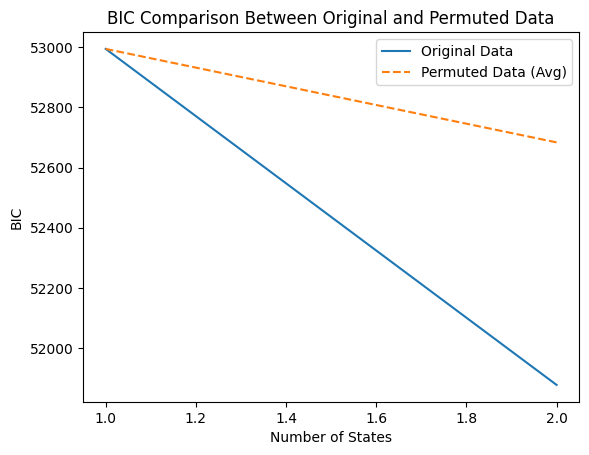

[-1117.0134779]


In [33]:
# Average BIC across permutations
df_BIC_permuted_avg = df_BIC_permuted.groupby('state_idx').agg({'BIC': 'mean'}).reset_index()

# Plotting
plt.plot(df_BIC['num_states'], df_BIC['BIC'], label='Original Data')
plt.plot(df_BIC_permuted_avg['state_idx'], df_BIC_permuted_avg['BIC'], label='Permuted Data (Avg)', linestyle='--')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.title('BIC Comparison Between Original and Permuted Data')
plt.show()

# Compute differences in BIC for original data
bic_diff = np.diff(df_BIC['BIC'])
print(bic_diff)

# Fit two-state GLM-HMMs 

In [ ]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states =  2      # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2      # input dimensions

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM

prior_sigma = 10
transition_alpha = 1

n_iter = 2 #10
parameters_ext_int = np.full([n_iter, 8], np.nan)
for idx in range(n_iter):
    print(idx)
    glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    
    #glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 3)
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
   
    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    del(glmhmm)


0
[[[-1.19789146 -0.04296052]]

 [[-0.99946458 -1.41167588]]]
[[1.19789146 0.04296052]
 [0.99946458 1.41167588]]
[1.19789146 0.99946458]
0
1
[[[-1.19834297 -0.04292162]]

 [[-0.99915863 -1.41079296]]]
[[1.19834297 0.04292162]
 [0.99915863 1.41079296]]
[1.19834297 0.99915863]
0


en gros, ext c'est pour la phase externale, int pour la phase internale où les coefs sont moins importants

In [ ]:

df_two_state_init = pd.DataFrame(parameters_ext_int, columns = ['theta_ext', 'prev_resp_ext',
                                                                'theta_int', 'prev_resp_int',
                                                                 'AA', 'AB', 'BA', 'BB'])


In [36]:
if save_data:
    df_two_state_init.to_csv(root_dir + '/HMM/two_state_init_param.csv', index = False)

In [37]:
df_two_state_init.mean()

contrast_ext             1.198100
previous_response_ext    0.043091
contrast_int             0.999131
previous_response_int    1.410793
AA                      -0.032504
AB                      -3.511188
BA                      -3.364398
BB                      -0.037510
dtype: float64

In [ ]:
df_two_state_init = pd.read_csv(root_dir + '/HMM/two_state_init_param.csv')
param_init_ext_int = df_two_state_init.mean().values

recovered_weights = -param_init_ext_int[0:4].reshape(2,1,2)
recovered_trans_mat = np.exp(param_init_ext_int[4:8].reshape(2,2))

[[[-1.19809966 -0.04309104]]

 [[-0.99913129 -1.41079339]]]
[-0.99913129 -1.41079339]


Text(0.5, 1.0, 'Weight recovery')

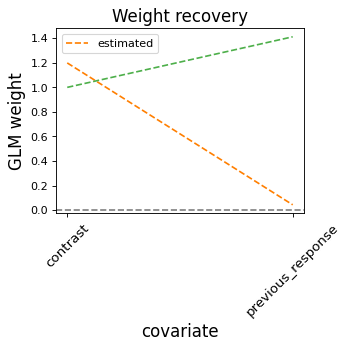

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']
for k in range(num_states):
    if k ==0:
        
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "estimated", linestyle = '--')
    else:
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['theta', 'prev_resp'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

on voit que la previous response n'a pas de poids dans le state n1.

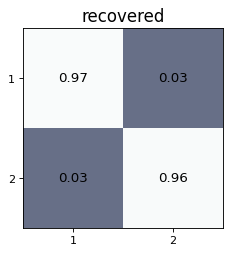

In [51]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

## Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [52]:
# run average model
prior_sigma = 10

glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
glmhmm.init_state_distn.params = np.log([0.5, 0.5])
glmhmm.observations.params = -param_init_ext_int[0:4].reshape(2,1,2)
glmhmm.transitions.params = (param_init_ext_int[4:8].reshape(2,2),)

_ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = False, tolerance=10**-4, verbose = False)
print(-glmhmm.observations.params)
index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])

[[[1.19823064 0.04152385]]

 [[0.99988245 1.4113977 ]]]


In [53]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

Text(0, 0.5, 'p(state)')

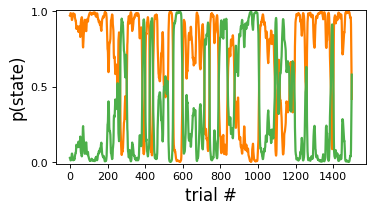

In [55]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 6 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][1:1500, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [56]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

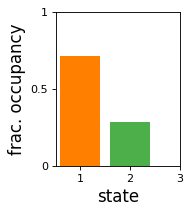

In [57]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [59]:
df = df.assign(Gl_Prob_State_ext = posterior_probs_concat[:,index_ext])
df = df.assign(Gl_Prob_State_int = posterior_probs_concat[:,index_int])

if save_data:
    df.to_csv(root_dir + '/HMM/Full_HMM.csv', index = False)